# Registration across Macaque MRI templates

* **Authors:** Nikoloz Sirmpilatze (NSirmpilatze@dpz.eu) & Chris Klink (c.klink@nin.knaw.nl)

* **Last updated:** 16 Feb 2020
* **Requirements:**
    * _python_ >= 3.7
    * _nipype_ >= 1.2.0
    * _nilearn_ >= 0.5.2
        * Used only for visualisation
    * _nibabel_ >= 2.3.3
    * _ANTs_ >= 2.1.0
        * _antsRegistration_,  _antsApplyTransforms_ and _antsAverageImages_ need to be in your path as executables    

The following templates are used: 
1. [NMT v1.2](https://github.com/jms290/NMT)
2. [NMT v1.3](https://github.com/jms290/NMT)
3. [D99](https://afni.nimh.nih.gov/Macaque)
4. [INIA19](https://www.nitrc.org/projects/inia19/https://www.nitrc.org/projects/inia19/)
5. [MNI macaque](http://www.bic.mni.mcgill.ca/ServicesAtlases/Macaque)
6. [Yerkes19](https://github.com/Washington-University/NHPPipelines)

Within this notebook, they are abbreviated as *NMTv12*, *NMTv13*, *D99*, *INIA*, *MNI*, and *YRK*     

**NB!** We do not provide copies of the actual templates (licenses often forbids redistribution), but instead suggest you get them at the source. We do offer the warp files that will be produced by this workflow. They can be downloaded from XXXX or XXXX. 

The end goal is to generate warp between each unique pair of the above 5 templates.
In total there are 10 pairs, and for each of them 2 warps are needed:
* forwards (A to B, e.g. *NMT_to_D99*)
* backwards (B to A, e.g. *D99_to_NMT*)

![warps](warp_pairs.png)

## Step 0: Preparations

### 0a. Import required libraries

In [34]:
import time
import os
import glob

import nibabel as nb
import shutil as sh

from itertools import combinations
from matplotlib import pyplot as plt

import nipype.interfaces.fsl as fsl # nipype interface for FSL
import nipype.interfaces.ants as ants # nipype interface for ANTs
from nilearn.plotting import plot_anat # Plotting function from nilearn

### 0b. Define relative paths to template files

The skull-stripped isotropic volumetric images are used for registration.
* For **NMT**, **D99**, and **YRK** the provided skull-stripped brains were used
* In **INIA** the brain stem extends further down the spinal cord compared to the other temlplates, so the braisn stem was truncated at a level similar to the others
* No skull-stripped image was provided with **MNI**, so the brain was segmented semi-manually using ITK-SNAP
* For **YRK** we used the version provided together with [NHPPipelines](https://github.com/Washington-University/NHPPipelines)

In [35]:
# ============================================
# NB! THIS COULD BE DIFFERENT FOR EVERY USER
# ============================================

# NS ---
#NMT_path = 'NMT/NMT_v1.2/'
#D99_path = 'D99/'
#INIA_path = 'inia19/'
#MNI_path = 'MNI_macaque/'
#YRK_path = 'NHPPipelines/global/templates/'

# CK ---
BASE_path     = '/home/chris/Documents/PRIME-RE/RheMAP/'   # repo base folder
TEMPLATE_path = BASE_path + 'templates/'                   # templates base folder
NMTv12_path   = TEMPLATE_path + 'NMT/NMT_v1.2/'
NMTv13_path   = TEMPLATE_path + 'NMT/NMT_v1.3/'
D99_path      = TEMPLATE_path + 'D99/'
INIA_path     = TEMPLATE_path + 'INIA/'
MNI_path      = TEMPLATE_path + 'MNI/'
YRK_path      = TEMPLATE_path + 'YRK/'

In [36]:
NMTv12_brain = NMTv12_path + 'NMT_SS.nii.gz'
NMTv13_brain = NMTv13_path + 'NMT_SS.nii.gz'
D99_brain    = D99_path + 'D99_template.nii.gz'
INIA_brain   = INIA_path + 'inia19-t1-brain_truncated.nii.gz'
MNI_brain    = MNI_path + 'macaque_25_model-MNI_brain.nii.gz'
YRK_brain    = YRK_path + 'MacaqueYerkes19_T1w_0.5mm_brain.nii.gz'

temp_names   = ['NMTv1.2', 'NMTv1.3', 'D99', 'INIA', 'MNI', 'YRK']
temp_brains  = [NMTv12_brain, NMTv13_brain, D99_brain, INIA_brain, MNI_brain, YRK_brain]

For some reason, the header of NMT_v1.3 has both qform_code and sform_code set to 5. This is handled poorly by nibabel (resets it to 0). Alignments will be ok, but visualisations will be off. Better change it to something >0, like 2 ('aligned').

In [ ]:
if NMTv13_brain in  locals():
    sh.copyfile(NMTv13_brain,NMTv13_brain + '.bak');
    img = nb.load(NMTv13_brain)
    hdr = img.header
    hdr.set_qform(hdr.get_qform(),code=2)
    hdr.set_sform(hdr.get_sform(),code=2)
    nb.save(img, NMTv13_brain)

### 0c. Plot template brains

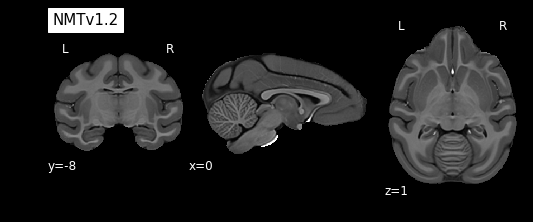

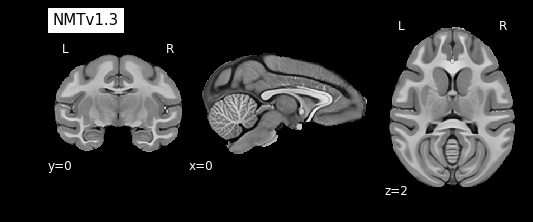

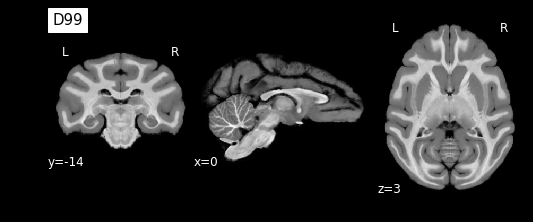

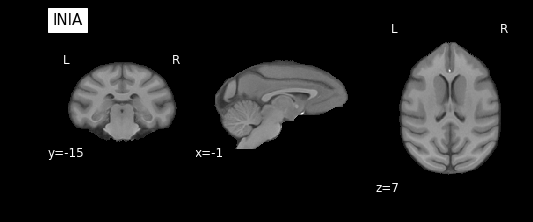

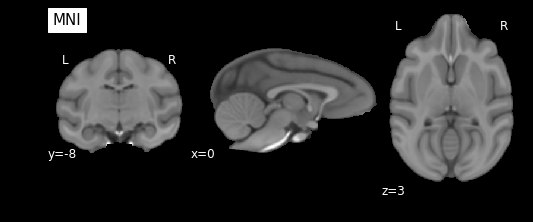

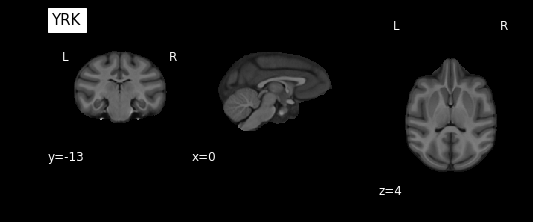

In [58]:
contrasts = [-1, 0, 0, -1, -0.5, 0] # strength of contrast in the plot_anat function ("dim")
for name, brain, con in zip(temp_names, temp_brains, contrasts):
    plot_anat(brain, display_mode='ortho', title=name,
              draw_cross=False, annotate=True, dim=con);

## Step 1: Linear registration
* This is performed using [ANTs](http://stnava.github.io/ANTs/) **Affine** registration (12 degrees of freedom: 3 translations + 3 rotations + 3 scalings + 3 shears)
* The _antsRegistration_ function is called through its [nipype wrapper](https://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.ants/registration.html#registration).
* [Anatomy of an antsRegistration call](https://github.com/ANTsX/ANTs/wiki/Anatomy-of-an-antsRegistration-call) does a good job of explaining what the various parameters mean.

### 1a. Define function

In [38]:
def register_linear(moving, target,
                    moving_prefix, target_prefix):
    """Linearly registers moving image to target image

    Parameters
    ----------
    moving: 3D NIFTI image file
    target: 3D NIFTI image file
    moving_prefix: string
        one of 'NMT', 'D99', 'INIA', 'MNI', 'YRK'
        is used in the naming of output files
    target_prefix: string
        one of 'NMT', 'D99', 'INIA', 'MNI', 'YRK'
        is used in the naming of output files

    Return
    ------
    Linear transformation matrix
        file named as '{moving_prefix}_to_{target_prefix}_0GenericAffine.mat'
    Transformed image
        moving image transformed into target image space
        file named as: {moving_prefix}_in_{target_prefix}_linear.nii.gz
    """
    
    rgstr = ants.registration.Registration(
           dimension=3,
           float=False,
           fixed_image=target,
           moving_image=moving,
           output_transform_prefix='{0}_to_{1}_'.format(moving_prefix, target_prefix),
           output_warped_image='{0}_in_{1}_linear.nii.gz'.format(moving_prefix, target_prefix),
           initial_moving_transform_com=0,
           winsorize_lower_quantile=0.05,
           winsorize_upper_quantile=0.95,
           interpolation='Linear',
           use_histogram_matching=[True],
           transforms=['Affine'],
           transform_parameters=[(0.1,)],
           metric=['MI'],
           metric_weight=[1],
           radius_or_number_of_bins=[32],
           sampling_strategy=['Regular'],
           sampling_percentage=[0.2],
           number_of_iterations=[[1000, 500, 250, 100]],
           convergence_threshold=[1e-6],
           convergence_window_size=[10],
           shrink_factors=[[8, 4, 2, 1]],
           smoothing_sigmas=[[3, 2, 1, 0]],
           sigma_units=['vox'])
    
    rgstr.run()

### 1b. Apply function to register all unique template pairs

In [ ]:
for names, brains in zip(combinations(temp_names, 2), combinations(temp_brains, 2)):

    mov_pref = names[0]
    targ_pref = names[1]
    mov_brain = brains[0]
    targ_brain = brains[1]
    
    print('\nLinearly registering {0} to {1} template...'.format(mov_pref, targ_pref))
    start_time = time.time()
    register_linear(mov_brain, targ_brain, mov_pref, targ_pref)
    end_time = time.time()
    print('Linear registration completed in  {0:.2f} minutes'.format((end_time - start_time)/60))


Linearly registering NMTv1.2 to NMTv1.3 template...


### 1c. Visualize linear registration results

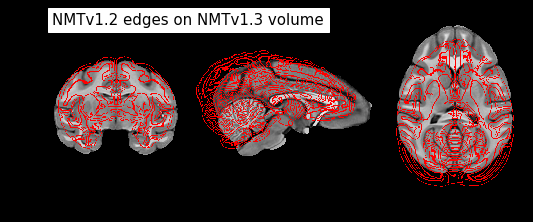

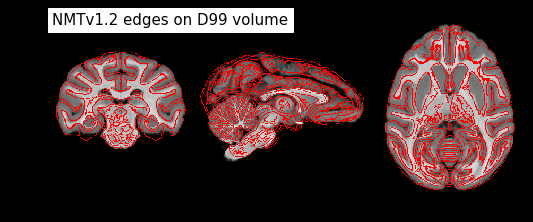

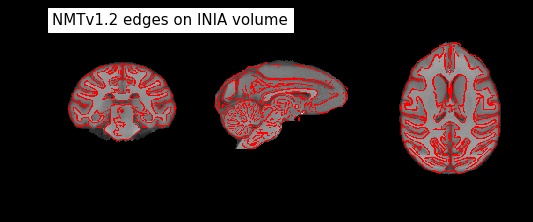

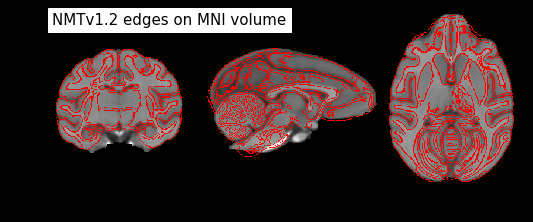

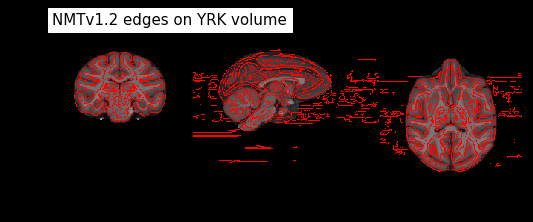

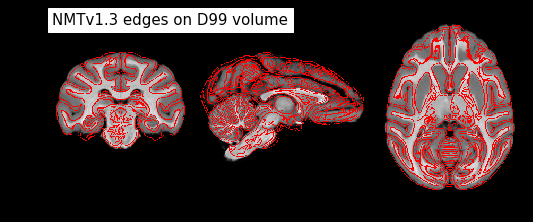

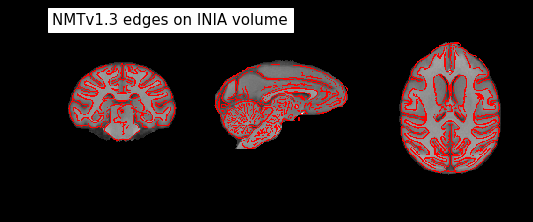

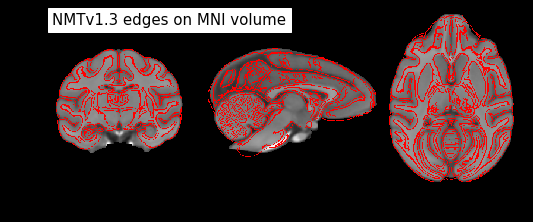

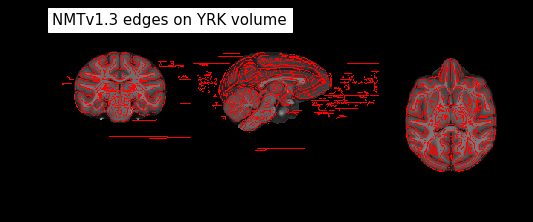

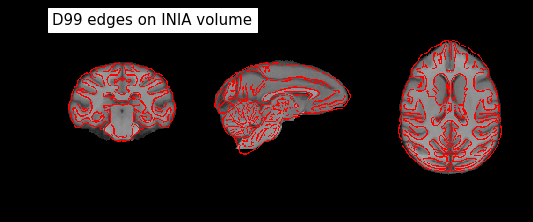

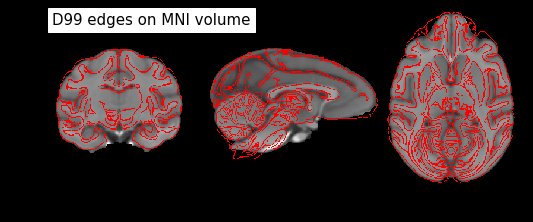

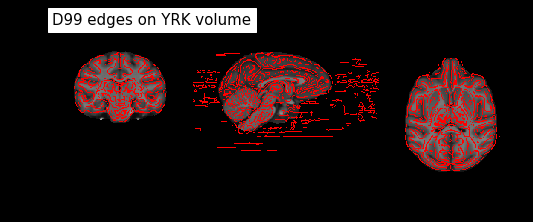

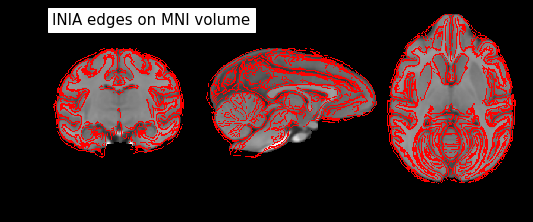

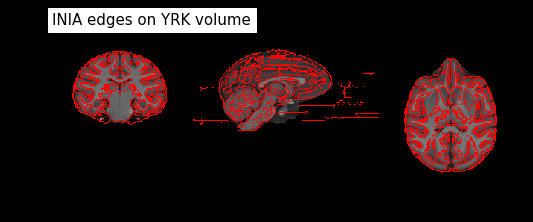

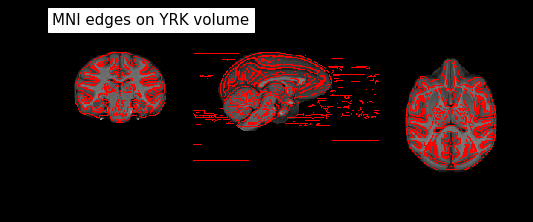

In [59]:
for names, brains in zip(combinations(temp_names, 2), combinations(temp_brains, 2)):

    mov_pref = names[0]
    targ_pref = names[1]
    mov_brain = brains[0]
    targ_brain = brains[1]
    targ_index = temp_names.index(targ_pref)
    
    display = plot_anat(targ_brain, display_mode='ortho',
                        title='{0} edges on {1} volume'.format(mov_pref, targ_pref),
                        draw_cross=False, annotate=False, dim=contrasts[targ_index])
    brain = '{0}_in_{1}_linear.nii.gz'.format(mov_pref, targ_pref)
    display.add_edges(brain)

## Step 2: Non-linear registration
* Symmetric Diffeomorphic ([SyN](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2276735/)) registration is performed using [ANTs](http://stnava.github.io/ANTs/).
* The starting point for this step is the transformed image from the previous (linear) step
* The _antsRegistration_ function is called through its [nipype wrapper](https://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.ants/registration.html#registration).
* [Anatomy of an antsRegistration call](https://github.com/ANTsX/ANTs/wiki/Anatomy-of-an-antsRegistration-call) does a good job of explaining what the various parameters mean.

### 2a. Define function

In [9]:
def register_SyN(moving, target,
                 moving_prefix, target_prefix):
    """Non-linearly registers moving image to target image using ANTs SyN

    Parameters
    ----------
    Same as register_linear function

    Return
    ------
    Non-linear forward warp
        file named as '{moving_prefix}_to_{target_prefix}_1Warp.nii.gz'
    Non-linear backward warp (inverse of the above)
        file named as '{moving_prefix}_to_{target_prefix}_1InverseWarp.nii.gz'
    Transformed image
        moving image transformed into target image space
        file named as: {moving_prefix}_in_{target_prefix}_linear+SyN.nii.gz
    """
    rgstr = ants.registration.Registration(
           dimension=3,
           float=False,
           fixed_image=target,
           moving_image=moving,
           output_transform_prefix='{0}_to_{1}_'.format(moving_prefix, target_prefix),
           output_warped_image='{0}_in_{1}_linear+SyN.nii.gz'.format(moving_prefix, target_prefix),
           initial_moving_transform_com=0,
           winsorize_lower_quantile=0.05,
           winsorize_upper_quantile=0.95,
           interpolation='Linear',
           use_histogram_matching=[True],
           transforms=['SyN'],
           transform_parameters=[(0.1,)],
           metric=['CC'],
           metric_weight=[1],
           radius_or_number_of_bins=[4],
           sampling_strategy=['Regular'],
           sampling_percentage=[0.2],
           number_of_iterations=[[500, 200, 50]],
           convergence_threshold=[1e-6],
           convergence_window_size=[10],
           shrink_factors=[[8, 4, 2]],
           smoothing_sigmas=[[3, 2, 1]],
           sigma_units=['vox'])
    
    rgstr.run()

### 2b. Apply function to register all unique template pairs

In [11]:
for names, brains in zip(combinations(temp_names, 2), combinations(temp_brains, 2)):

    mov_pref = names[0]
    targ_pref = names[1]
    mov_brain = '{0}_in_{1}_linear.nii.gz'.format(mov_pref, targ_pref)
    targ_brain = brains[1]
    
    print('\nNon-linearly registering {0} to {1} template...'.format(mov_pref, targ_pref))
    start_time = time.time()
    register_SyN(mov_brain, targ_brain, mov_pref, targ_pref)
    end_time = time.time()
    print('Non-linear registration completed in  {0:.2f} minutes'.format((end_time - start_time)/60))


Non-linearly registering NMT to D99 template...
Non-linear registration completed in  187.93 minutes

Non-linearly registering NMT to INIA template...
Non-linear registration completed in  35.19 minutes

Non-linearly registering NMT to MNI template...
Non-linear registration completed in  119.11 minutes

Non-linearly registering NMT to YRK template...
Non-linear registration completed in  61.99 minutes

Non-linearly registering D99 to INIA template...
Non-linear registration completed in  31.90 minutes

Non-linearly registering D99 to MNI template...
Non-linear registration completed in  127.73 minutes

Non-linearly registering D99 to YRK template...
Non-linear registration completed in  61.57 minutes

Non-linearly registering INIA to MNI template...
Non-linear registration completed in  122.97 minutes

Non-linearly registering INIA to YRK template...
Non-linear registration completed in  62.50 minutes

Non-linearly registering MNI to YRK template...
Non-linear registration completed 

### 2c: Visualize non-linear registration results

In [ ]:
for names, brains in zip(combinations(temp_names, 2), combinations(temp_brains, 2)):

    mov_pref = names[0]
    targ_pref = names[1]
    targ_brain = brains[1]
    targ_index = temp_names.index(targ_pref)
    
    display = plot_anat(targ_brain, display_mode='ortho',
                        title='{0} edges on {1} volume'.format(mov_pref, targ_pref),
                        draw_cross=False, annotate=False, dim=contrasts[targ_index])
    brain = '{0}_in_{1}_linear+SyN.nii.gz'.format(mov_pref, targ_pref)
    display.add_edges(brain)

## Step 3: Derive composite warps by combining linear and non-linear steps
* This is done with the _antsApplyTransforms_ function, using its [nipype wrapper](https://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.ants/resampling.html#applytransforms).
* **Caution:** the order with which transforms are passed is akin to linear algebra notation, so first transform is applied last
* Both forward (templateA-to-templateB) and backward (templateB-to-templateA) warps are computed

### 3a. Define function

In [12]:
def combine_transforms(moving, target,
                       moving_prefix, target_prefix):

    """Combines linear transform with non-linear warp to generate a composite warp

    Parameters
    ----------
    Same as register_linear function

    Return
    ------
    Composite forward warp
        file named as '{moving_prefix}_to_{target_prefix}_CompositeWarp.nii.gz'
    Composite backward warp (inverse of the above)
        file named as '{target_prefix}_to_{moving_prefix}_CompositeWarp.nii.gz'
    """
    
    forward = ants.ApplyTransforms(
            input_image=moving,
            output_image='{0}_to_{1}_CompositeWarp.nii.gz'.format(moving_prefix, target_prefix),
            reference_image=target,
            transforms=['{0}_to_{1}_1Warp.nii.gz'.format(moving_prefix, target_prefix),
                        '{0}_to_{1}_0GenericAffine.mat'.format(moving_prefix, target_prefix)],
            dimension=3,
            print_out_composite_warp_file=True)
    forward.run()

    backward = ants.ApplyTransforms(
            input_image=target,
            output_image='{1}_to_{0}_CompositeWarp.nii.gz'.format(moving_prefix, target_prefix),
            reference_image=moving,
            transforms=['{0}_to_{1}_0GenericAffine.mat'.format(moving_prefix, target_prefix),
                        '{0}_to_{1}_1InverseWarp.nii.gz'.format(moving_prefix, target_prefix)],
            invert_transform_flags=[True, False], # invert the linear transform
            dimension=3,
            print_out_composite_warp_file=True)
    backward.run()

### 3b. Apply function to generate all 10 composite warp pairs

In [13]:
for names, brains in zip(combinations(temp_names, 2), combinations(temp_brains, 2)):

    mov_pref = names[0]
    targ_pref = names[1]
    mov_brain = brains[0]
    targ_brain = brains[1]

    print('\nCreating composite warps between {0} and {1} templates...'.format(mov_pref, targ_pref))
    start_time = time.time()
    combine_transforms(mov_brain, targ_brain, mov_pref, targ_pref)
    end_time = time.time()
    print('Composite warps computed in {0:.2f} minutes'.format((end_time - start_time)/60))


Creating composite warps between NMT and D99 templates...
Composite warps computed in 1.86 minutes

Creating composite warps between NMT and INIA templates...
Composite warps computed in 1.14 minutes

Creating composite warps between NMT and MNI templates...
Composite warps computed in 1.32 minutes

Creating composite warps between NMT and YRK templates...
Composite warps computed in 1.18 minutes

Creating composite warps between D99 and INIA templates...
Composite warps computed in 1.15 minutes

Creating composite warps between D99 and MNI templates...
Composite warps computed in 1.27 minutes

Creating composite warps between D99 and YRK templates...
Composite warps computed in 1.24 minutes

Creating composite warps between INIA and MNI templates...
Composite warps computed in 0.73 minutes

Creating composite warps between INIA and YRK templates...
Composite warps computed in 0.61 minutes

Creating composite warps between MNI and YRK templates...
Composite warps computed in 0.91 minu

### 3c. Visually assess the derived composite warp pairs
* First use the derived composite warps to transform brains in both directions

In [14]:
for names, brains in zip(combinations(temp_names, 2), combinations(temp_brains, 2)):

    mov_pref = names[0]
    targ_pref = names[1]
    mov_brain = brains[0]
    targ_brain = brains[1]
    
    forward = ants.ApplyTransforms(
            input_image=mov_brain,
            output_image='{0}_in_{1}_composite.nii.gz'.format(mov_pref, targ_pref),
            reference_image=targ_brain,
            transforms=['{0}_to_{1}_CompositeWarp.nii.gz'.format(mov_pref, targ_pref)],
            dimension=3)
    backward = ants.ApplyTransforms(
            input_image=targ_brain,
            output_image='{1}_in_{0}_composite.nii.gz'.format(mov_pref, targ_pref),
            reference_image=mov_brain,
            transforms=['{1}_to_{0}_CompositeWarp.nii.gz'.format(mov_pref, targ_pref)],
            dimension=3)

    print('\nTransforming {0} into {1} space...'.format(mov_pref, targ_pref))
    start_time = time.time()
    forward.run()
    end_time = time.time()
    print('Transformation complete in {0:.2f} minutes'.format((end_time - start_time)/60))
    print('Transforming {1} into {0} space...'.format(mov_pref, targ_pref))
    start_time = time.time()
    backward.run()
    end_time = time.time()
    print('Transformation complete in {0:.2f} minutes'.format((end_time - start_time)/60))


Transforming NMT into D99 space...
Transformation complete in 0.25 minutes
Transforming D99 into NMT space...
Transformation complete in 0.24 minutes

Transforming NMT into INIA space...
Transformation complete in 0.05 minutes
Transforming INIA into NMT space...
Transformation complete in 0.24 minutes

Transforming NMT into MNI space...
Transformation complete in 0.18 minutes
Transforming MNI into NMT space...
Transformation complete in 0.21 minutes

Transforming NMT into YRK space...
Transformation complete in 0.08 minutes
Transforming YRK into NMT space...
Transformation complete in 0.24 minutes

Transforming D99 into INIA space...
Transformation complete in 0.05 minutes
Transforming INIA into D99 space...
Transformation complete in 0.25 minutes

Transforming D99 into MNI space...
Transformation complete in 0.18 minutes
Transforming MNI into D99 space...
Transformation complete in 0.22 minutes

Transforming D99 into YRK space...
Transformation complete in 0.08 minutes
Transforming Y

* Then, overlay the transformed (by composite warps) brains on target brains for visualization
* two plots (forward/backward) will be generated for each template pair

qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0


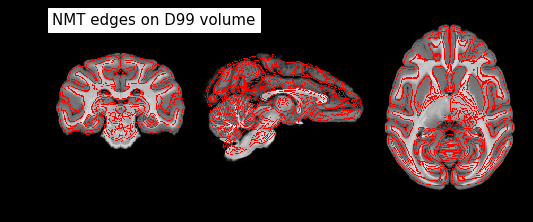

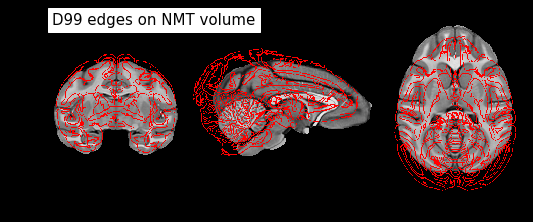

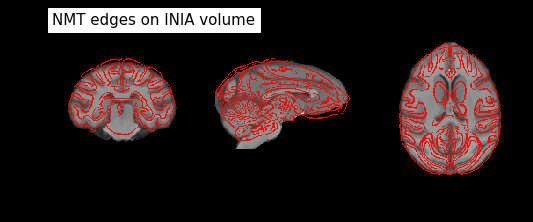

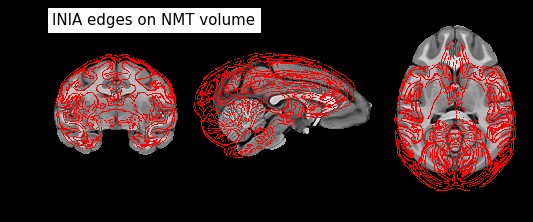

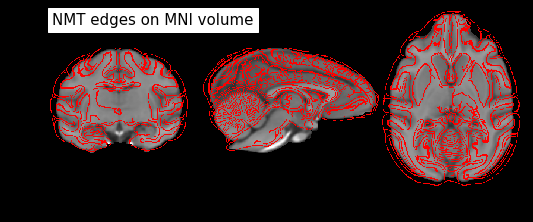

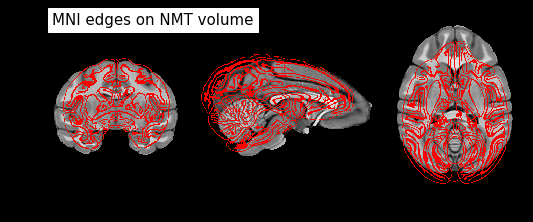

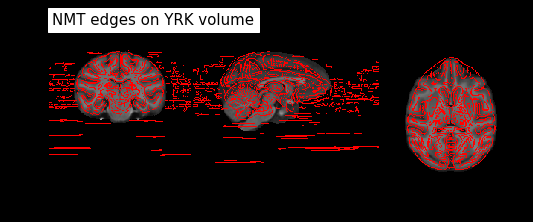

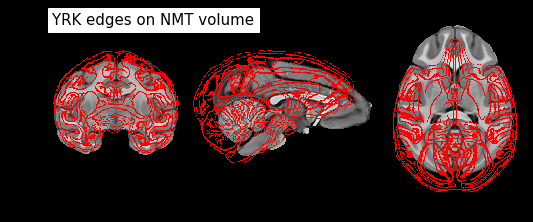

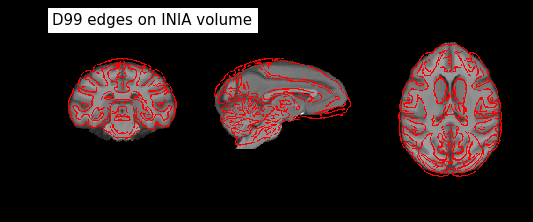

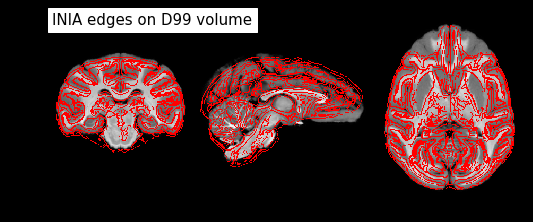

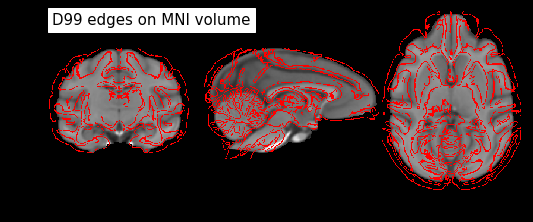

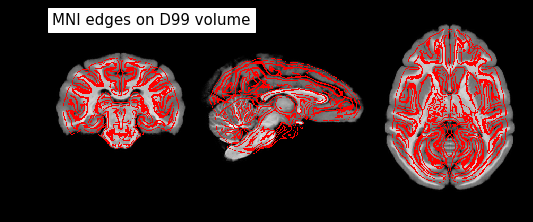

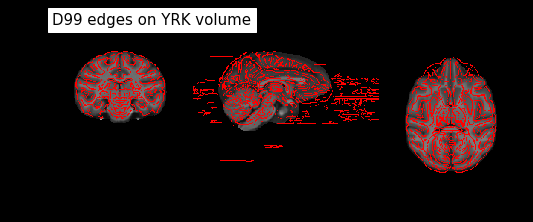

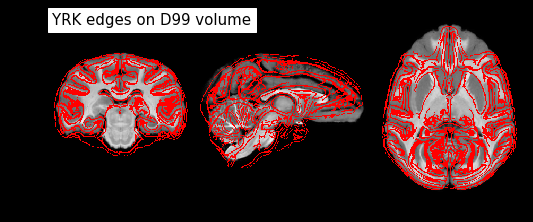

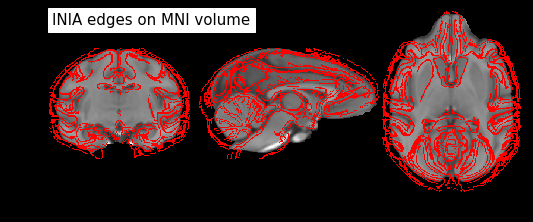

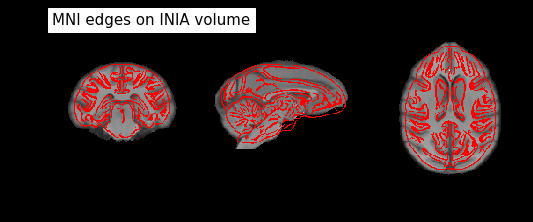

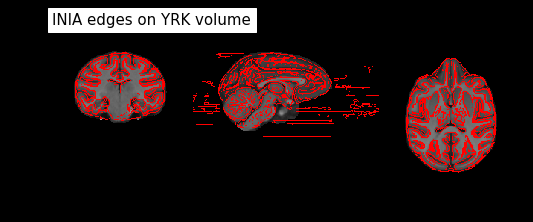

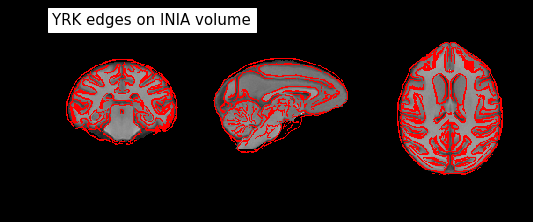

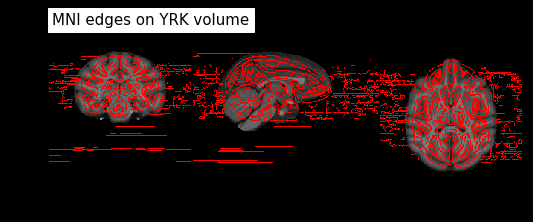

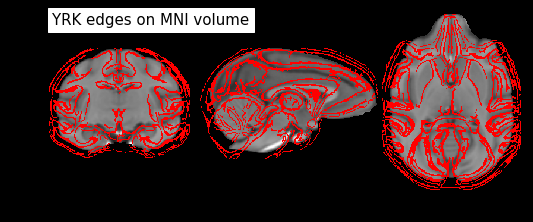

In [15]:
for names, brains in zip(combinations(temp_names, 2), combinations(temp_brains, 2)):

    mov_pref = names[0]
    targ_pref = names[1]
    mov_brain = brains[0]
    targ_brain = brains[1]
    mov_index = temp_names.index(mov_pref)
    targ_index = temp_names.index(targ_pref)
    
    display = plot_anat(targ_brain, display_mode='ortho',
                        title='{0} edges on {1} volume'.format(mov_pref, targ_pref),
                        draw_cross=False, annotate=False, dim=contrasts[targ_index])
    brain = '{0}_in_{1}_composite.nii.gz'.format(mov_pref, targ_pref)
    display.add_edges(brain)
    
    display = plot_anat(mov_brain, display_mode='ortho',
                        title='{1} edges on {0} volume'.format(mov_pref, targ_pref),
                        draw_cross=False, annotate=False, dim=contrasts[mov_index])
    brain = '{1}_in_{0}_composite.nii.gz'.format(mov_pref, targ_pref)
    display.add_edges(brain)

### 4. We will now create the average 'meta'-template in NMT space (just because we can)
* Get all the templates (in NMT space) & average them into a 'MetaTemplate'
* Plot the result

In [21]:
avg = ants.AverageImages(
    dimension=3,
    output_average_image="MetaTemplate_in_NMT.nii.gz",
    normalize=True,
    images=[NMT_brain,
           "D99_in_NMT_composite.nii.gz", 
           "INIA_in_NMT_composite.nii.gz", 
           "MNI_in_NMT_composite.nii.gz",
           "YRK_in_NMT_composite.nii.gz"])
avg.run();

plot_anat("MetaTemplate_in_NMT.nii.gz", display_mode='ortho', title="MetaTemplate in NMT",
              draw_cross=False, annotate=True, dim=con);

200216-11:31:27,231 nipype.interface INFO:
	 stdout 2020-02-16T11:31:27.230968: bigimage 4 maxSize [253, 347, 245]
200216-11:31:27,524 nipype.interface INFO:
	 stdout 2020-02-16T11:31:27.524253: Setting physcal space of output average image based on largest image 
200216-11:31:27,534 nipype.interface INFO:
	 stdout 2020-02-16T11:31:27.524253: Averaging 5 images with dim = 3 vector components 1
200216-11:31:27,535 nipype.interface INFO:
	 stdout 2020-02-16T11:31:27.535751: reading /home/chris/Documents/PRIME-RE/RheMAP/templates/NMT/NMT_v1.3/NMT_SS.nii.gz
200216-11:31:28,796 nipype.interface INFO:
	 stdout 2020-02-16T11:31:28.796229: reading D99_in_NMT_composite.nii.gz
200216-11:31:30,848 nipype.interface INFO:
	 stdout 2020-02-16T11:31:30.848475: reading INIA_in_NMT_composite.nii.gz
200216-11:31:32,814 nipype.interface INFO:
	 stdout 2020-02-16T11:31:32.814352: reading MNI_in_NMT_composite.nii.gz
200216-11:31:34,741 nipype.interface INFO:
	 stdout 2020-02-16T11:31:34.741742: reading YRK

### 5. Clean-up
* Put all files in sensible places
* Create subfolders for linear and non-linear warps, and for the warped volumes

In [33]:
os.makedirs( BASE_path + "warps/linear" ,exist_ok=True)
os.makedirs( BASE_path + "warps/nonlinear" ,exist_ok=True)
os.makedirs( BASE_path + "warps/composite" ,exist_ok=True)

[os.rename( os.getcwd() + '/' + f, BASE_path + "warps/linear/" + f) for f in glob.glob('*Affine.mat')];
[os.rename( os.getcwd() + '/' + f, BASE_path + "warps/nonlinear/" + f) for f in glob.glob('*_to_*_1Warp.nii.gz')];
[os.rename( os.getcwd() + '/' + f, BASE_path + "warps/nonlinear/" + f) for f in glob.glob('*_to_*_1InverseWarp.nii.gz')];
[os.rename( os.getcwd() + '/' + f, BASE_path + "warps/composite/" + f) for f in glob.glob('*_to_*_CompositeWarp.nii.gz')];

os.makedirs( BASE_path + "warped_templates/linear" ,exist_ok=True)
os.makedirs( BASE_path + "warped_templates/nonlinear" ,exist_ok=True)
os.makedirs( BASE_path + "warped_templates/composite" ,exist_ok=True)

[os.rename( os.getcwd() + '/' +  f, BASE_path + "warped_templates/linear/" + f) for f in glob.glob('*_in_*linear.nii.gz')];
[os.rename( os.getcwd() + '/' +  f, BASE_path + "warped_templates/nonlinear/" + f) for f in glob.glob('*_in_*linear+SyN.nii.gz')];
[os.rename( os.getcwd() + '/' +  f, BASE_path + "warped_templates/composite/" + f) for f in glob.glob('*_in_*composite.nii.gz')];